# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on six
datasets. As part of the practical you should briefly read the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
import operator
from collections import Counter
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB #todo just for testing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import  mutual_info_classif
from scipy.stats import norm

Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


You can import statistic libraries for the implementation of the distributions. We recommend using the statistical functions provided by `scipy.stats`. Read the documentation here: https://docs.scipy.org/doc/scipy/reference/stats.html


In [2]:
# Distribution for continuous features
class ContFeatureParam:

    def estimate(self, X):
        ################################################################################################################
        '''
        compute MLE estimator for the parameters of the gaussian distribution
        '''
        #need to check, if variance is too small, to avoid div by zero
        X = X.astype(np.float)
        variance = np.nanvar(X)
        if variance < 1e-6:
            variance=1e-6
        return np.nanmean(X), variance
        ################################################################################################################

    def get_probability(self, val, mean, var):
        ################################################################################################################
        '''
        - val: a datapoint (vector) x
        - mean: mean of the given feature
        - var: variance of the given feature

        calculate log probability that val happens given the gaussian distribution for a feature
        using the probability density function (-> density value of data on distribution)
        '''
        temp =  stats.norm.logpdf(np.float64(val),mean,np.sqrt(var))
        temp[np.isnan(temp)] = 0#if nan values were present, replace with 0
        return temp
        ################################################################################################################

########################################################################################################################
########################################################################################################################

# Distribution for binary features
class BinFeatureParam:

    def estimate(self, X, featureClasses):
        ################################################################################################################
        '''
        for every category in a binary feature store its count and length for a specific feature and class
        '''
        lst = X.tolist()
        params={}
        for cat in featureClasses:
            dict={}
            dict['count'] = lst.count(cat) #the number of the category belonging to a specific class in feature j
            #to handle missing values, we remove all missing values from here
            cleanedList = [i for i in lst if not str(i)  in ['nan', np.nan]]
            #the length of a category belong to a specific class without missing values for a given feature
            dict['length'] = len(cleanedList)
            params[cat] = dict
        return params
        ################################################################################################################

    def get_probability(self, val, theta, alpha=1.0 ):
        ################################################################################################################
        '''
        val: datapoint (vector) to be evaluated
        theta: theta_jc,l
        return log probability laplacian smoothed with default alpha=1.0 for every val
        '''
        tempvec=[]
        for i in val:
            if i in ['nan', np.nan]:#skip:
                tempvec.append(0)
            elif i in theta.keys():
                count = theta[i]['count']
                length = theta[i]['length']
                #laplacian smoothing, d=2, number of classes, alpha=1.0 => add-one smoothing
                freq = np.log(count+alpha) - np.log(length+alpha*2)
                tempvec.append(freq)
            else:#was not fitted
                counterVal = list(theta.items())[0][1]#get the other value for a binary feature
                count = counterVal['count']#number of occurences of the other value
                length = counterVal['length']
                #bernoulli -> counter probability
                freq = np.log(1 - (count+alpha)/(length+alpha*2))
                tempvec.append(freq)

        return np.array(tempvec)
        ################################################################################################################


########################################################################################################################
########################################################################################################################

# Distribution for categorical features
class CatFeatureParam:

    def estimate(self, X, featureClasses):
        ################################################################################################################
        lst = X.tolist()
        params={}
        for cat in featureClasses:
            dict={}
            dict['count'] = lst.count(cat)#count number of occurences of this category in a feature j belonging to class c
            cleanedList = [i for i in lst if not str(i)  in ['nan', np.nan]]#remove nan values from list to get length
            dict['length'] = len(cleanedList)
            params[cat] = dict
        return params
        ################################################################################################################

    def get_probability(self, val, theta, alpha=1.0):
        ################################################################################################################
        tempvec=[]

        d = len(theta.keys())
        for i in val:
            if  i in ['nan', np.nan]:#skip:
                tempvec.append(0)
            elif i in theta.keys():
                count = theta[i]['count']
                length = theta[i]['length']
                #laplacian smoothing, d=2, number of classes, alpha=1.0 => add-one smoothing
                freq = np.log(count+alpha) - np.log(length+alpha*d)
                tempvec.append(freq)
            else:#not in fitted params
                cLength = list(theta.items())[0][1]['length']#get length of categories in feature j belonging to the class c
                #laplacian smoothed
                freq = np.log(alpha) - np.log(cLength+alpha*d)
                tempvec.append(freq)

        return np.array(tempvec)
        ################################################################################################################

########################################################################################################################
########################################################################################################################

Let us now implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

![alt text](pics/fit_4.png)


**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

![alt text](pics/predict_3.png)

In [3]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types=[], num_classes=0):
        ################################################################################################################
        self.feature_types = feature_types
        self.num_classes = num_classes
        # initialize distribution classes
        self.binary = BinFeatureParam()
        self.real = ContFeatureParam()
        self.categorical = CatFeatureParam()
        #additional attributes
        self.params=[]
        self.prior = {}
        self.classes = {}
        self.error = False
        self.yy = np.empty(0)
        ################################################################################################################
        
    
    # The function uses the input data to estimate all the parameters of the NBC
    # You should use the parameters based on the types of the features
    def fit(self, X, y):
        ################################################################################################################
        num_features = X.shape[1] # assuming X is matrix
        params=[0]*num_features # initialize array for the estimated parameters

        #estimate pi: Pi_c = N_c / N, s.t. sum Pi_c = 1
        self.classes = Counter(y) #count every class c in y in a dictionary and returns their # of occurrences
        for c in sorted(self.classes.keys()): #put in a dict the class c and its marginal distr.
            self.prior[c] = np.log(self.classes[c]/sum(self.classes.values()))
        #---------------------------------------------------------------------------------------------------------------
        self.yy = np.array(sorted(self.classes.keys()))#used for argmax to be able to handle non integer labels
        #---------------------------------------------------------------------------------------------------------------

        # iterate through all features and based on its type (r,b,c), estimate the parameters---------------------------
        for j in range(num_features):
            feature_type = self.feature_types[j]
            # the current column vector (feature) in X at position j
            feature_j = X[:,j]
            #class params are inserted by feature j, then class c: params[j][c] returns theta_j_c
            class_params = {}

            #iterate through every class val for feature j--------------------------------------------------------------
            for count, val in enumerate(sorted(self.classes.keys())):
                x_filtered = feature_j[np.where(y == val)] #vector for feature j where all entries belong to class y
                try: #'r', 'b', 'c' feature types
                    lClasses = list(set(feature_j))#get the classes l for this feature
                    if feature_type == 'b':#binary
                        lC = [i for i in lClasses if not i in ['nan', np.nan]]
                        class_params[val] = self.binary.estimate(x_filtered, [lC[0]])
                    elif feature_type == 'r':#continuous(real)
                        class_params[val] = self.real.estimate(x_filtered)
                    elif feature_type == 'c':#categorical
                        lC = [i for i in lClasses if not i in ['nan', np.nan]]
                        class_params[val] = self.categorical.estimate(x_filtered, lC)
                    else: #throw Exception if an invalid feature type is given
                        raise ValueError
                except ValueError:
                    print('Val error', feature_type)
                    self.error=True
                    break
            #-----------------------------------------------------------------------------------------------------------
            params[j] = class_params
        #---------------------------------------------------------------------------------------------------------------
        self.params = params #assign the params to the class
        ################################################################################################################
                

    def predict(self, X):
        # The function takes the new data matrix X as input, and predicts the class for the data
        ################################################################################################################
        if not self.error:#if a ValueError was raised, no computations are made in predict
            m, n = X.shape
            posterior={}
            for i, c in enumerate(sorted(self.classes.keys())):#iterate through all classes c---------------------------
                log_likelihood = 0 # initialize the product as 1 to be able to multiply
                for j in range(n):#iterate through all features j-------------------------------------------------------
                    if self.feature_types[j] == 'r': #if continuous
                        log_likelihood += self.real.get_probability(X[:,j], self.params[j][c][0], self.params[j][c][1])
                    elif self.feature_types[j] == 'b':
                        log_likelihood += self.binary.get_probability(X[:,j], self.params[j][c])
                    elif self.feature_types[j] == 'c':
                        log_likelihood += self.categorical.get_probability(X[:,j], self.params[j][c])
                    else:#not possible since raises error in fit
                        pass
                    log_prior = self.prior[c]
                    posterior[c] = log_prior+log_likelihood #take priors into log, class
                #-------------------------------------------------------------------------------------------------------
            #-----------------------------------------------------------------------------------------------------------
            res = np.array(tuple(posterior.values()))
            return self.yy[np.argmax(res, axis=0)]
        else:
            return 0
        ################################################################################################################


**Implementation Issues**
- Feel free to add auxiliary functions.
- Don't forget to compute $p(y=c | \pi)$ 
- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- Your implementation should be able to handle missing values
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).


You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.RandomState(seed=42).permutation(N)
Xtrain = X[shuffler[:Ntrain]]
#
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
#
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy)

##just for testing to compare
nbc_iris_scipy = GaussianNB()
nbc_iris_scipy.fit(Xtrain, ytrain)
yhat2 = nbc_iris_scipy.predict(Xtest)
test_accuracy2 = np.mean(yhat2 == ytest)
print("Accuracy Gaussian NB:", test_accuracy2)

##

Accuracy: 0.9333333333333333
Accuracy Gaussian NB: 0.9333333333333333


## Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of
the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

In [5]:
def compareNBCvsLR(nbc, lr, X, X_LR, y, num_runs=200, num_splits=10, ):
    ####################################################################################################################

    '''
    inputs:
        nbc: Naive Bayes Classifier
        lr: Logistic Regression Classifier
        X, y: data
        XLR: data processed for Logistic Regression
        num_runs: we need repeat num_runs times and store average results
        num_splits: we want to compare the two models on increasingly larger training sets.
        num_splits defines the number of increasing steps.
    outputs:
        the arrays of the test errors across the runs of the two classifiers
    '''

    err_nbc = np.zeros((num_runs,num_splits))
    err_lr = np.zeros((num_runs,num_splits))
    N, D = X.shape

    for i in range(num_runs):

        #use stratified sampling with shuffling before doing the sampling
        Xtrain_, Xtest, ytrain_, ytest = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)
        Xtrain_LR_, XtestLR, ytrain_LR_, ytestLR = train_test_split(X_LR, y, test_size=0.2, stratify=y, shuffle=True)


        for n in range(1,num_splits+1):#loop from 10% to 100% of the training data used
            Ntrain = int(0.8 * N *(n/num_splits))

            #NB
            Xtrain = Xtrain_[:Ntrain,]
            ytrain = ytrain_[:Ntrain,]
            nbc.fit(Xtrain, ytrain)
            nbc_yhat = nbc.predict(Xtest)
            err_nbc[i][n-1] = 1-np.mean(nbc_yhat == ytest)

            #LR
            XtrainLR = Xtrain_LR_[:Ntrain,]
            ytrain_LR = ytrain_LR_[:Ntrain,]
            lr.fit(XtrainLR, ytrain_LR)
            lr_yhat = lr.predict(XtestLR)
            err_lr[i][n-1] = 1-np.mean(lr_yhat == ytestLR)
        #---------------------------------------------------------------------------------------------------------------
    tst_errs_nbc = np.mean(err_nbc, axis=0)
    tst_errs_lr = np.mean(err_lr, axis=0)
    return tst_errs_nbc, tst_errs_lr

    ####################################################################################################################

The utility function below defines the function for plotting. 

In [6]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 12.0 KB

Classes distribution:  2    50
1    50
0    50
Name: species, dtype: int64
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000 

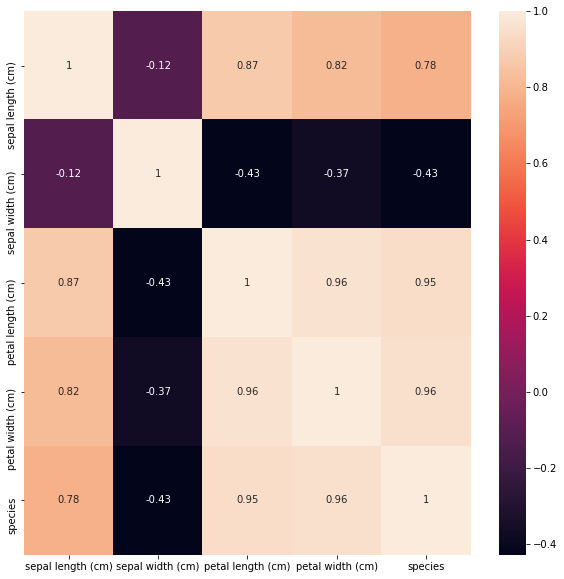

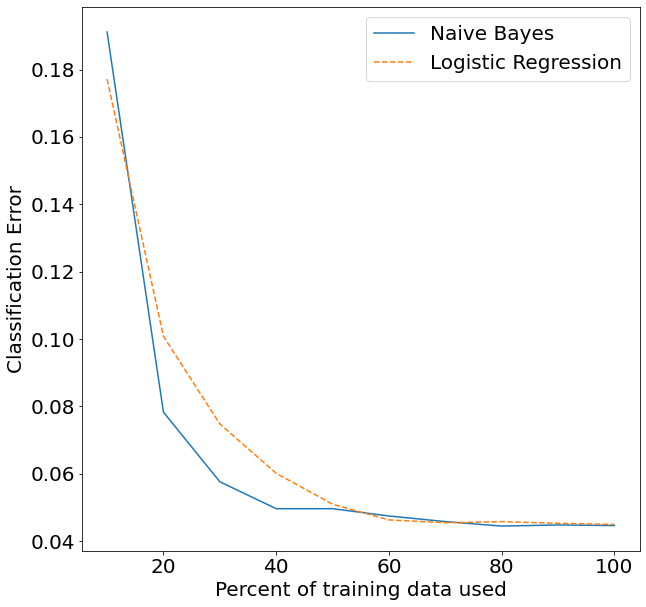

In [7]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
n=200
missing_values = ['?', 'n/a', 'nan']
########################################################################################################################
########################################################################################################################
########################################################################################################################
from sklearn.datasets import load_iris
iris_obj = load_iris()
# the code transform the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))
iris.info()
print('\nClasses distribution: ', iris['species'].value_counts())
print(iris.describe())
##
fig_i1=plt.figure()
sns.heatmap(iris.corr(),annot=True)

#check mutual information
mi_iris = list(mutual_info_classif(iris.iloc[:,0:4], iris.iloc[:,4]))
print('Mutual information', iris.columns, '\n', mi_iris)
#=> very high mutual information. all features are needed.

#standarization
iris = iris.to_numpy()
Xx, yy = iris[:,0:4], iris[:,4]
Xx_iris_scaled = StandardScaler().fit_transform(X=Xx)

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
lr_iris = LogisticRegression(max_iter=200, multi_class='multinomial')

tst_errs_nbc_iris, tst_errs_lr_iris = compareNBCvsLR(nbc_iris, lr_iris, Xx_iris_scaled, Xx_iris_scaled, yy, n, 10)
makePlot(tst_errs_nbc_iris, tst_errs_lr_iris)
print('Accuracy over ', n, 'runs with NBC (100% of training data): ', 1-tst_errs_nbc_iris[-1])
print('Accuracy over ', n, 'runs with LR (100% of training data): ', 1-tst_errs_lr_iris[-1])

########################################################################################################################

**Dataset 1: Iris Dataset Report**

For this dataset we first checked the feature types and if there were are any missing values, which turned out not to
be the case. Since the features were already numeric, no encoding was needed for the Logistic Regression.
We used a heatmap to see correlation of between all columns (incl. feature), we noted that petal width and length
strongly correlate, while noticeably sepal width and sepal length do not. We also checked the mutual information between
the features and the label species and noted that the values are high.

Since the mutual information between the label species and the feature sepal width is comparatively low to the other
features, so we toyed with the idea of dropping it
from our data set, but choose not to do so, since we were not trying to achieve the highest accuracy as possible here,
 we were also not using a validation data set, and it would also likely lead to overfitting the data.

We also checked the distribution of the label species, and noted, that that all three classes were equally distributed.
Since the features were neither normalized nor standardized, we decided to standardize them,
since they are all continuous values.

We noted, as expected from the findings of the paper of Andrew Y. Ng and Michael I. Jordan, that
Naive Bayes reaches quickly a steep decrease in error, though Logistic Regression plateaus on average lower
than Naive Bayes here. So with little training data, NB was the clear favorite on this data set,
but Logistic Regression tended to have the better performance with the full data set on average, although they were
usually very close. Notably, after around 30-50% of the training data,
NB tends to not improve much more but rather plateaus there and further data does not improve performance.
########################################################################################################################
########################################################################################################################


**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

/Users/fabian/opt/miniconda3/envs/bokeh-tutorial/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


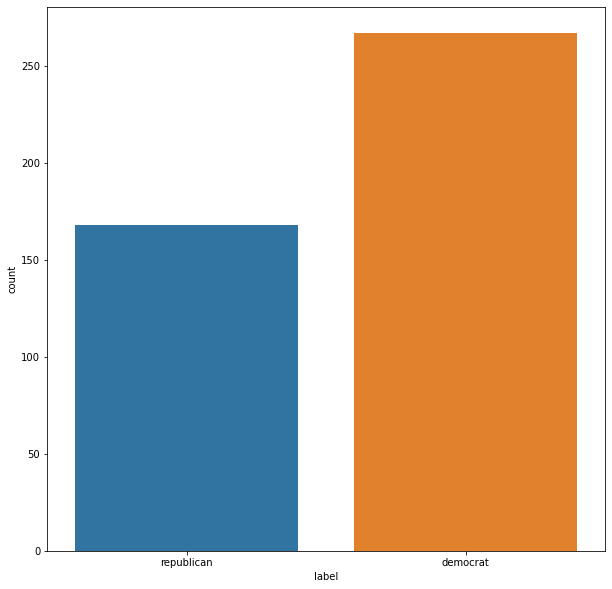

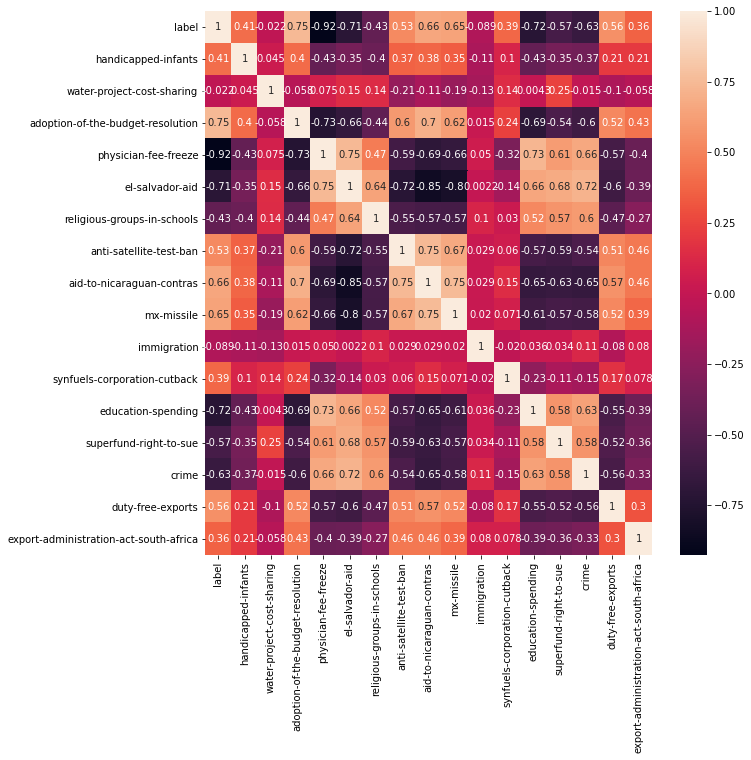

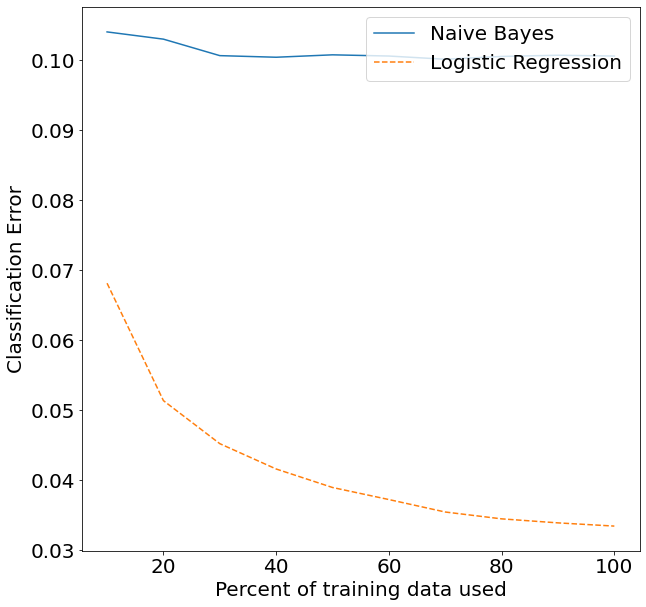

In [8]:
########################################################################################################################

# 1. Class Name: 2 (democrat, republican)
# 2. handicapped-infants: 2 (y,n)
# 3. water-project-cost-sharing: 2 (y,n)
# 4. adoption-of-the-budget-resolution: 2 (y,n)
# 5. physician-fee-freeze: 2 (y,n)
# 6. el-salvador-aid: 2 (y,n)
# 7. religious-groups-in-schools: 2 (y,n)
# 8. anti-satellite-test-ban: 2 (y,n)
# 9. aid-to-nicaraguan-contras: 2 (y,n)
# 10. mx-missile: 2 (y,n)
# 11. immigration: 2 (y,n)
# 12. synfuels-corporation-cutback: 2 (y,n)
# 13. education-spending: 2 (y,n)
# 14. superfund-right-to-sue: 2 (y,n)
# 15. crime: 2 (y,n)
# 16. duty-free-exports: 2 (y,n)
# 17. export-administration-act-south-africa: 2 (y,n)

voting = pd.read_csv('./datasets/voting.csv', na_values=missing_values)
voting.info()
voting.label.value_counts() #=> ~60%dem, 40% rep. OK but small data set

plt.figure()
v1 = sns.countplot(voting['label'])

voting.label.replace({'democrat':1, 'republican':0}, inplace = True)
encodeMap = {'y' : 1, 'n' : 0}
voting_encoded = voting
for col in voting.columns.drop('label'):#iterate through all columns, but skip label since already encoded
    voting_encoded[col] = voting[col].map(encodeMap)

#For LR
voting_encoded_cols = voting_encoded.columns
# voting_encoded
#check features depending on label
# voting_encoded.groupby('education-spending')['label'].mean() #-> not many dems in favor (?)
# voting_encoded.groupby('physician-fee-freeze')['label'].mean() #->99% republicans in favor
# vote_filled = voting_encoded.dropna()
#voting dataset has about half missing data, use kNN to impute them
imputer = KNNImputer(n_neighbors=5,weights="distance", metric='nan_euclidean')
vote_filled = pd.DataFrame(imputer.fit_transform(voting_encoded),columns=voting_encoded_cols)
# kNN leads to non-binary results in the columns. If knn returned value >= 0.5, replace with 1, else 0.
# print(vote_filled.describe())
for col in vote_filled.columns:
    vote_filled[col] = np.where(vote_filled[col] >=0.5, 1, 0)
# print(vote_filled.describe())

#plot encoding in heatmap to show pearson correlation
# vote_filled = voting_encoded
fig_v2=plt.figure()
sns.heatmap(vote_filled.corr(),annot=True)
#=> some very strong correlation between some features and the label. It seems that some features (physician-fee-freeze,
# education spending) correlate highly with the label, meaning that they might be clear indicators that the
# congressman(woman) is a dem or rep.
#check mutual information
# mi_vote = list(mutual_info_classif(vote_filled.iloc[:,1:17], vote_filled['label']))
# print('Mutual information', vote_filled.columns, '\n', mi_vote) #handicapped-infants,
# mx-missile have no mutual information with the label, could try dropping it

vote_filled = vote_filled.to_numpy()#For LR
vote_encoded = voting_encoded.to_numpy()#For NB
Xx_vote_LR, yy_vote = vote_filled[:,1:17], vote_filled[:,0]
Xx_vote = vote_encoded[:,1:17]#, voting_encoded[:,0]

feat_types_vote = list(16*'b')
nbc_vote = NBC(feature_types=feat_types_vote, num_classes=2)
lr_vote = LogisticRegression(max_iter=200)

tst_errs_nbc_vote, tst_errs_lr_vote = compareNBCvsLR(nbc_vote, lr_vote, Xx_vote, Xx_vote_LR, yy_vote, n, 10)
makePlot(tst_errs_nbc_vote , tst_errs_lr_vote)
print('Accuracy over ', n, 'runs with NBC (100% of training data): ', 1-tst_errs_nbc_vote[-1])
print('Accuracy over ', n, 'runs with LR (100% of training data): ', 1-tst_errs_lr_vote[-1])

########################################################################################################################


**Dataset 2: Voting Dataset Report**

For this dataset we noticed straight away, that we were dealing with many missing values, in fact, if we were to just
drop them,about 50% of the examples would go missing, with such a small data set that was unfathomable,
since the missing values could possibly also be imputed here.
For the NB dataset, we did not fill any missing values since our algorithm is able to handle them, and
for the Logistic Regression dataset we used the KNNimputer with the default value of
k=5 for the kNN, to help us fill these values.
Since non numerical binary features were present, we encoded them into binary 0 and 1's. Dummy variables/Onehotencoding
would not comply with the conditional independence of features that Naive Bayes assumes.
We looked into the data and checked some features, also with the help of the heatmap.
Some features turned out to correlate strongly with the label.
They were clear indicators for the label, e.g. physician-fee-freeze.
This was also checked with the group-by method to check the distribution over the feature, given the label.
Checking the mutual information lead to no additional findings over the correlations.
Ultimately, we used all features, dropping some not have a significant performance improvement. We were also interested
in the result of dropping all na values, and it turned out to be mostly the logistic regression
that got affected from this, though the results were in fact comparable.

For this dataset our NB implementation did not perform as well as the Logistic Regression did, in fact
the Logistic Regression was much more powerful.
Again, the NB reached quickly its performance plateau, although the performance only
varied slightly over the percentage of training data used.
We also noted, that our NB result were
in order with the figure of the paper, although the Logistic Regression performance not so much.


########################################################################################################################
########################################################################################################################

**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   buying         1728 non-null   object
 1   maint          1728 non-null   object
 2   doors          1728 non-null   object
 3   persons        1728 non-null   object
 4   lug_boot       1728 non-null   object
 5   safety         1728 non-null   object
 6   acceptability  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
       buying  maint doors persons lug_boot safety acceptability
count    1728   1728  1728    1728     1728   1728          1728
unique      4      4     4       3        3      3             4
top     vhigh  vhigh     4       4    small   high         unacc
freq      432    432   432     576      576    576          1210

Classes distribution:
 unacc    1210
acc       384
good       69
vgood      65
Name: acceptability, dtype: int64
<class 'pandas.core.frame.D

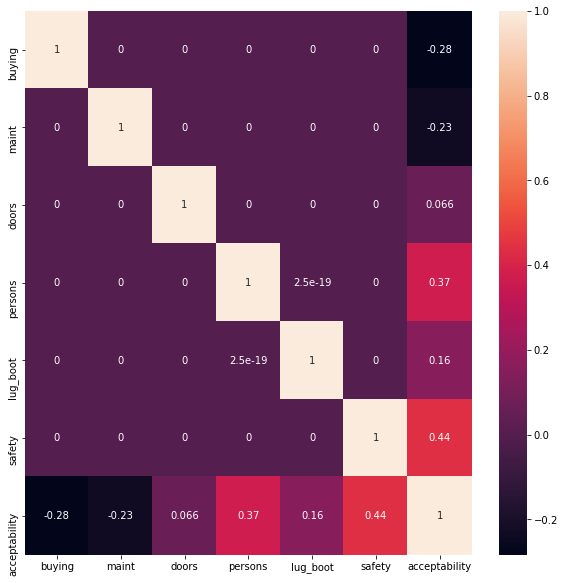

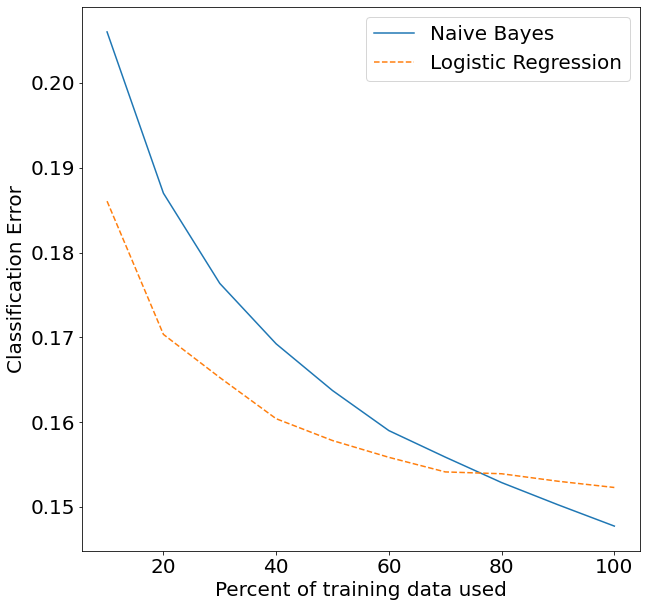

In [9]:
########################################################################################################################

#
# Class Values:
# unacc, acc, good, vgood
#
# Attributes:
# buying: vhigh, high, med, low.
# maint: vhigh, high, med, low.
# doors: 2, 3, 4, 5more.
# persons: 2, 4, more.
# lug_boot: small, med, big.
# safety: low, med, high.

car = pd.read_csv('./datasets/car.csv')
car.info()
#plot feature and label distributions
classes = list(car.columns)
# for c in classes:
#     plt.figure()
#     plt.title("Column: '%s'"%c)
#     sns.countplot(car[c])


print(car.describe())
#no missing values
# print('Has Null: ', car.isnull().any().any()) #no null values
# print('Has Na: ', car.isna().any().any()) #no na values
print('\nClasses distribution:\n', car['acceptability'].value_counts()) #=> distribution is skewed towards unacc

#encode the columns for LR
cars_encoded=car
cars_encoded.buying.replace({'vhigh':3, 'high':2, 'med':1, 'low':0}, inplace = True)
cars_encoded.maint.replace({'vhigh':3, 'high':2, 'med':1, 'low':0}, inplace = True)
cars_encoded.doors.replace({'5more':5}, inplace=True)
cars_encoded.persons.replace({'more':5}, inplace=True)
cars_encoded.lug_boot.replace({'small':0,'med':1,'big':2}, inplace=True)
cars_encoded.safety.replace({'low':0,'med':1,'high':2}, inplace=True)
cars_encoded.acceptability.replace({'unacc':0, 'acc':1, 'good':2, 'vgood':3}, inplace = True)
t = pd.to_numeric(cars_encoded.doors)
cars_encoded.doors = t
t = pd.to_numeric(cars_encoded.persons)
cars_encoded.persons = t

cars_encoded.head() #check encoding
#plot encoding in heatmap to show correlation
fig_c2=plt.figure()
sns.heatmap(cars_encoded.corr(),annot=True) #=> very low correlation values between features themselves and also between features and label
cars_encoded.info()
dropped_cols_cars = cars_encoded.drop(columns=['doors'])
#check mutual information
mi_cars = list(mutual_info_classif(cars_encoded.iloc[:,0:6], cars_encoded['acceptability']))
print('Mutual information', cars_encoded.columns, '\n', mi_cars)
#=>doors has extremely low mutual information with the label, can try dropping it
# idx_cars = [i for i in range(len(mi_cars)) if mi_cars[i] < 1e-2] #get idx to drop irrelevant features
# print('idx', idx_cars)
# dropped_cols_cars = cars_encoded
# if len(idx_cars) > 0: #check if there were any below the threshold to drop
#     dropped_cols_cars.drop(dropped_cols_cars.columns[idx_cars], axis=1, inplace=True)

#=> dropping feature 'doors' did not have any effect.

#For LR
cars_encoded = dropped_cols_cars.to_numpy()
Xx_carsLR, yy_cars = cars_encoded[:,0:5], cars_encoded[:,5]
#For NB
car = car.drop(columns=['doors'])
Xx_cars  = car.to_numpy()[:,0:5]

feat_types_cars = list(5*'c')
nbc_cars = NBC(feature_types=feat_types_cars, num_classes=4)
lr_cars = LogisticRegression(max_iter=200, solver='newton-cg',multi_class='multinomial')#newton-cg seems to give very good results for this task

tst_errs_nbc_cars, tst_errs_lr_cars = compareNBCvsLR(nbc_cars, lr_cars, Xx_cars, Xx_carsLR, yy_cars, n, 10)
makePlot(tst_errs_nbc_cars, tst_errs_lr_cars)
print('Accuracy over ', n, 'runs with NBC (100% of training data): ', 1-tst_errs_nbc_cars[-1])
print('Accuracy over ', n, 'runs with LR (100% of training data): ', 1-tst_errs_lr_cars[-1])

########################################################################################################################

**Dataset 3: Car Evaluation Dataset Report**

For Logistic Regression, all features were ordinally encoded, since the features are ordinal,
 although there is no distance metric between the categories of the features, there is an order between them.
 For NB we left the dataset as is and did no encodings.

 We also noted from the heatmap, that there are not only low correlations between themselves, but also to the label,
 in fact only two features (safety, persons) have higher correlation values to the label acceptability,
 that can also be seen from the mutual information calculation. Although we did drop the feature 'doors', since its
 mutual information with the label was extremely low, and there was also no correlation to the label,
 this did not lead to any performance increasement. We also tried dropping more features, to no avail.

With the car dataset, our NB had a strong performance increase in the beginning, but also kept on improving,
and lowering the classification error, and ultimately outperforming the Logistic Regression.
It would be interesting to see, how much the performance would increase if more data were to be provided.

########################################################################################################################
########################################################################################################################

**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    278 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  285 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB
left     152
right    134
Name: breast, dtype: int64
Mutual information Index(['Class', 'age', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat', 'menopause_0', 'menopause_1',
       'menopause_2'],
      dtype='object') 
 [0.015011162366243669, 0.03420152164214829, 0.06583604387395248, 0.0260569936002177

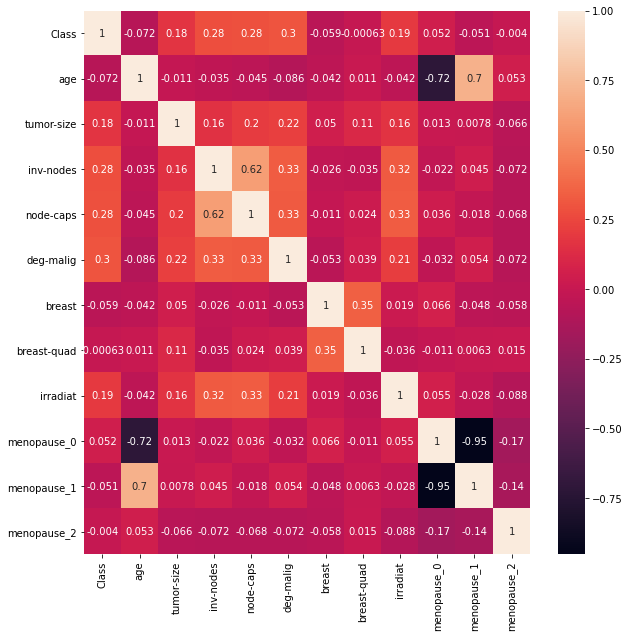

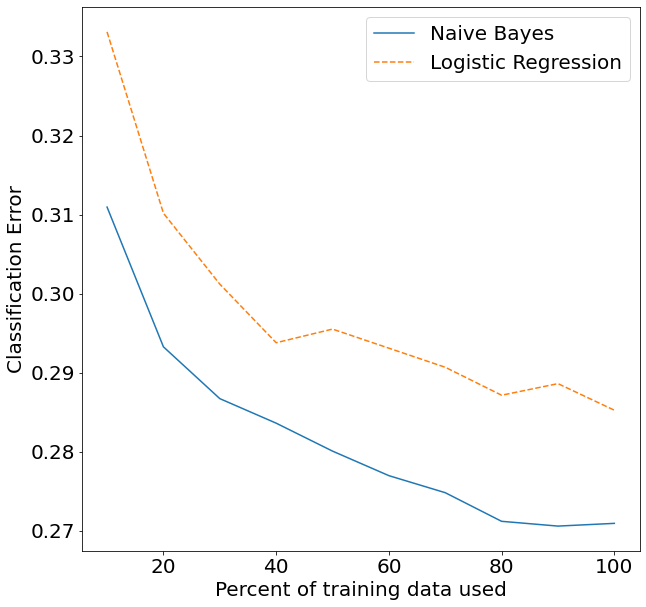

In [10]:
########################################################################################################################

# Attribute Information:
# 1. Class: no-recurrence-events, recurrence-events
# 2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
# 3. menopause: lt40, ge40, premeno.
# 4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59.
# 5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39.
# 6. node-caps: yes, no.
# 7. deg-malig: 1, 2, 3.
# 8. breast: left, right.
# 9. breast-quad: left-up, left-low, right-up, right-low, central.
# 10. irradiat: yes, no.

cancer = pd.read_csv('./datasets/breast-cancer.csv', na_values = missing_values)
cancer.info()
# print(cancer.describe())
# print('Has Null: ', cancer.isnull().any().any())
# print('Has Na: ', cancer.isna().any().any())
# print('\nClasses distribution:\n', cancer['Class'].value_counts()) #=> distribution is skewed towards g

#for LR, not needed for NB. for simplicity reasons to keep same test set.
cancer.Class.replace({'no-recurrence-events':0,'recurrence-events':1}, inplace=True)
cancerLR = cancer.copy()

print(cancer.breast.value_counts())
#handle null values
# print('node-caps distrib: ', cancer['node-caps'].value_counts()) #distribution is skewed heavily towards 0, so to keep the distribution impute the na values with 0
# cancerLR['node-caps'].fillna(0, inplace=True)

# print('breast-quad distrib: ', cancer['breast-quad'].value_counts()) #check distribution of values
# cancerLR.dropna(inplace=True) #since only one nan value left and distribution does not show a clear favorite, drop it


#Encodings
cancerLR.irradiat.replace({'yes':1, 'no':0}, inplace=True)
cancerLR['node-caps'].replace({'yes':1, 'no':0}, inplace=True)
cancerLR.breast.replace({'left':0, 'right':1}, inplace=True)
#not using ordinalEncoder, since it did not sort lexicographically resulting in wrong encodings
cancerLR.age.replace({'20-29': 0, '30-39': 1, '40-49': 2, '50-59': 3, '60-69': 4, '70-79': 5  }, inplace=True) #ordinal, prefer labelencoding over one-hot encoding to not lose relationship
cancerLR['tumor-size'].replace({'0-4':0, '5-9':1 , '10-14':2 , '15-19':3 ,
'20-24': 4, '25-29': 5, '30-34': 6, '35-39':7 , '40-44':8 , '45-49': 9, '50-54':10 }, inplace=True) #ordinal, prefer labelencoding
cancerLR['inv-nodes'].replace({'0-2':0, '3-5':1, '6-8':2, '9-11':3, '12-14':4, '15-17':5, '18-20':6,
                             '21-23':7, '24-26':8, '27-29':9, '30-32':10, '33-35':11, '36-39':12 }, inplace=True)
cancerLR['breast-quad'].replace({'left_low':0 , 'right_low':1 , 'central':2, 'left_up':3, 'right_up':4}, inplace=True)
cancerLR.menopause.replace({'premeno': 0, 'ge40': 1, 'lt40': 2}, inplace=True)
#encoding of label only because heatmap needs it
# cancerLR.Class.replace({'no-recurrence-events':0,'recurrence-events':1}, inplace=True)

cols=['menopause']
enc=OneHotEncoder(sparse=False)
for col in cols:
    data=cancerLR[[col]]
    temp = enc.fit_transform(cancerLR[[col]])
    temp2=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in data[col].value_counts().index])
    temp2=temp2.set_index(cancerLR.index.values)
    cancerLR = pd.concat([cancerLR, temp2], axis=1)
    cancerLR.drop(columns=[col], inplace=True)

#plot encoding in heatmap to show pearson correlation
fig_cancer1=plt.figure()
sns.heatmap(cancerLR.corr(),annot=True)

# cancer.info()


cancer_cols = cancerLR.columns
imputer = KNNImputer(n_neighbors=5)
cancerLR = pd.DataFrame(imputer.fit_transform(cancerLR),columns=cancer_cols)
## dropping columns did not seem to improve the results
# dropped_cols_cancer = cancer
mi_cancer = list(mutual_info_classif(cancerLR.iloc[:,1:12], cancerLR.iloc[:,0]))
print('Mutual information', cancerLR.columns, '\n', mi_cancer)
# idx_cancer = [i for i in range(len(mi_cancer)) if mi_cancer[i] < 0.01] #get idx to drop irrelevant features
# print('idx', idx_cancer)
# if len(idx_cancer) > 0: #check if there were any below the threshold to drop
#     cancer.drop(cancer.columns[idx_cancer], axis=1, inplace=True)

print('Has Null: ', cancerLR.isnull().any().any())
print('Has Na: ', cancerLR.isna().any().any())
cancerLR = cancerLR.to_numpy()
cancer = cancer.to_numpy()

Xx_cancerLR, yy_cancer = cancerLR[:,1:12], cancerLR[:,0]
Xx_cancer = cancer[:,1:10]

feat_types = list(4*'c' + 'b' + 'c' + 'b' +'c'+ 'b') #+list('r' for i in range(Xx_iono.shape[1]-1))#first feature is binary, the others are continuous
# feat_types = list(4*'c' + 13*'b') #+list('r' for i in range(Xx_iono.shape[1]-1))#first feature is binary, the others are continuous
nbc_cancer = NBC(feature_types=feat_types, num_classes=2)
lr_cancer = LogisticRegression(max_iter=200)
#
tst_errs_nbc_cancer, tst_errs_lr_cancer = compareNBCvsLR(nbc_cancer, lr_cancer, Xx_cancer, Xx_cancerLR, yy_cancer, n, 10)
makePlot(tst_errs_nbc_cancer, tst_errs_lr_cancer)
print('Accuracy over ', n, 'runs with NBC (100% of training data): ', 1-tst_errs_nbc_cancer[-1])
print('Accuracy over ', n, 'runs with LR (100% of training data): ', 1-tst_errs_lr_cancer[-1])

#Note: if using pycharm or some other ide's, heatmap might disappear. It gets shown in Jupyter Notebook though.

########################################################################################################################

**Dataset 4: Breast Cancer Dataset Report**

For the logistic regression dataset we encoded most features ordinally, and encoded the feature menopause using the
onehot encoding.
We also filled the few missing values for LR with the kNN imputer, using the default k value.
By checking the features, we found that most had surprisingly little mutual information with the label.
Unsurprisingly, the one-hot encoded values had high correlation values to each other,
as did age and the menopause features.

Also in this dataset we were able to see a sharp decline in the beginning,
though more data provided to be useful and the performance kept on increasing.
The graph from the Logistic Regression was also in the realm of our expectations,
though its performance was not great either. Ultimately, both had very similar performances,
but they did not get very high.


########################################################################################################################
########################################################################################################################



**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   351 non-null    int64  
 1   feature2   351 non-null    int64  
 2   feature3   351 non-null    float64
 3   feature4   351 non-null    float64
 4   feature5   351 non-null    float64
 5   feature6   351 non-null    float64
 6   feature7   351 non-null    float64
 7   feature8   351 non-null    float64
 8   feature9   351 non-null    float64
 9   feature10  351 non-null    float64
 10  feature11  351 non-null    float64
 11  feature12  351 non-null    float64
 12  feature13  351 non-null    float64
 13  feature14  351 non-null    float64
 14  feature15  351 non-null    float64
 15  feature16  351 non-null    float64
 16  feature17  351 non-null    float64
 17  feature18  351 non-null    float64
 18  feature19  351 non-null    float64
 19  feature20  351 non-null    float64
 20  feature21 

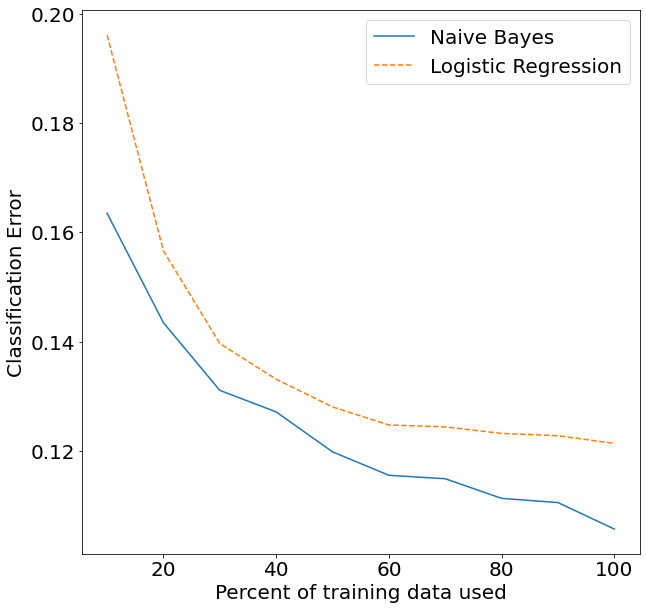

In [11]:
########################################################################################################################

# All 34 are continuous
# The 35th attribute is either "good" or "bad" according to the definition summarized above.
# This is a binary classification task.
#

ionosphere = pd.read_csv('./datasets/ionosphere.csv', na_values = missing_values)
#IONO INFOS for preprocessing. g for good, b for bad

ionosphere.info()
# print(ionosphere.describe())
ionosphere = ionosphere.drop(columns=['feature2']) #drop feature 2, is a constant and thus does not contain any useful information
# ionosphere = ionosphere.loc[:,['feature1', 'label']]
print(ionosphere)
# ionosphere.label.replace({'g':1, 'b':0}, inplace=True) #if want to use integer as label. not needed for our NBC algo

# ionosphere.info()
print('Has Null: ', ionosphere.isnull().any().any())
print('Has Na: ', ionosphere.isna().any().any())
print('\nClasses distribution:\n', ionosphere['label'].value_counts()) #=> distribution is skewed towards g


dropped_cols_ionosphere = ionosphere
# print('label', ionosphere['label'])
mi_iono = list(mutual_info_classif(ionosphere.iloc[:,0:-1], ionosphere['label']))
print('Mutual information', ionosphere.columns, '\n', mi_iono)
idx_iono = [i for i in range(len(mi_iono)) if mi_iono[i] < 1e-1] #get idx to drop irrelevant features
# print('idx', idx)
# if len(idx_iono) > 0: #check if there were any below the threshold to drop
#     dropped_cols_ionosphere.drop(dropped_cols_ionosphere.columns[idx_iono], axis=1, inplace=True)
# -> no columns dropped

iono = dropped_cols_ionosphere.to_numpy()
Xx_iono, yy_iono = iono[:,0:-1], iono[:,-1]
#first feature is binary but can also try as continuous.
# the others are continuous
feat_types = ['r']+list('r' for i in range(Xx_iono.shape[1]-1))

nbc_iono = NBC(feature_types=feat_types, num_classes=2)
lr_iono = LogisticRegression(max_iter=200)

tst_errs_nbc_iono, tst_errs_lr_iono = compareNBCvsLR(nbc_iono, lr_iono, Xx_iono, Xx_iono, yy_iono,n, 10)
makePlot(tst_errs_nbc_iono, tst_errs_lr_iono)
print('Accuracy over ', n, 'runs with NBC (100% of training data): ', 1-tst_errs_nbc_iono[-1])
print('Accuracy over ', n, 'runs with LR (100% of training data): ', 1-tst_errs_lr_iono[-1])

########################################################################################################################

**Dataset 5: Ionosphere Dataset Report**

For this dataset we noticed that feature 'feature2' was a constant, so it did not add any information,
and was to be dropped. For the feature 'feature1' the data document labelled it as continuous,
so naturally we tried it as a continuous feature, but also as a binary feature. Regarding it as continuous,
did eventually result in better performance.
Noticeably, this data set contained comparatively high mutual information scores, so it was clear to us,
that there was no need to drop any features to compare performance gains.


The graph also showed the biggest increase in performance in the beginning, but it did not plateau over the dataset,
meaning that more data would have been helpful here, and likely lead to even better performance.
We noticed, that our NB model outperformed the Logistic Regression

########################################################################################################################
########################################################################################################################




**Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   208 non-null    float64
 1   feature2   208 non-null    float64
 2   feature3   208 non-null    float64
 3   feature4   208 non-null    float64
 4   feature5   208 non-null    float64
 5   feature6   208 non-null    float64
 6   feature7   208 non-null    float64
 7   feature8   208 non-null    float64
 8   feature9   208 non-null    float64
 9   feature10  208 non-null    float64
 10  feature11  208 non-null    float64
 11  feature12  208 non-null    float64
 12  feature13  208 non-null    float64
 13  feature14  208 non-null    float64
 14  feature15  208 non-null    float64
 15  feature16  208 non-null    float64
 16  feature17  208 non-null    float64
 17  feature18  208 non-null    float64
 18  feature19  208 non-null    float64
 19  feature20  208 non-null    float64
 20  feature21 

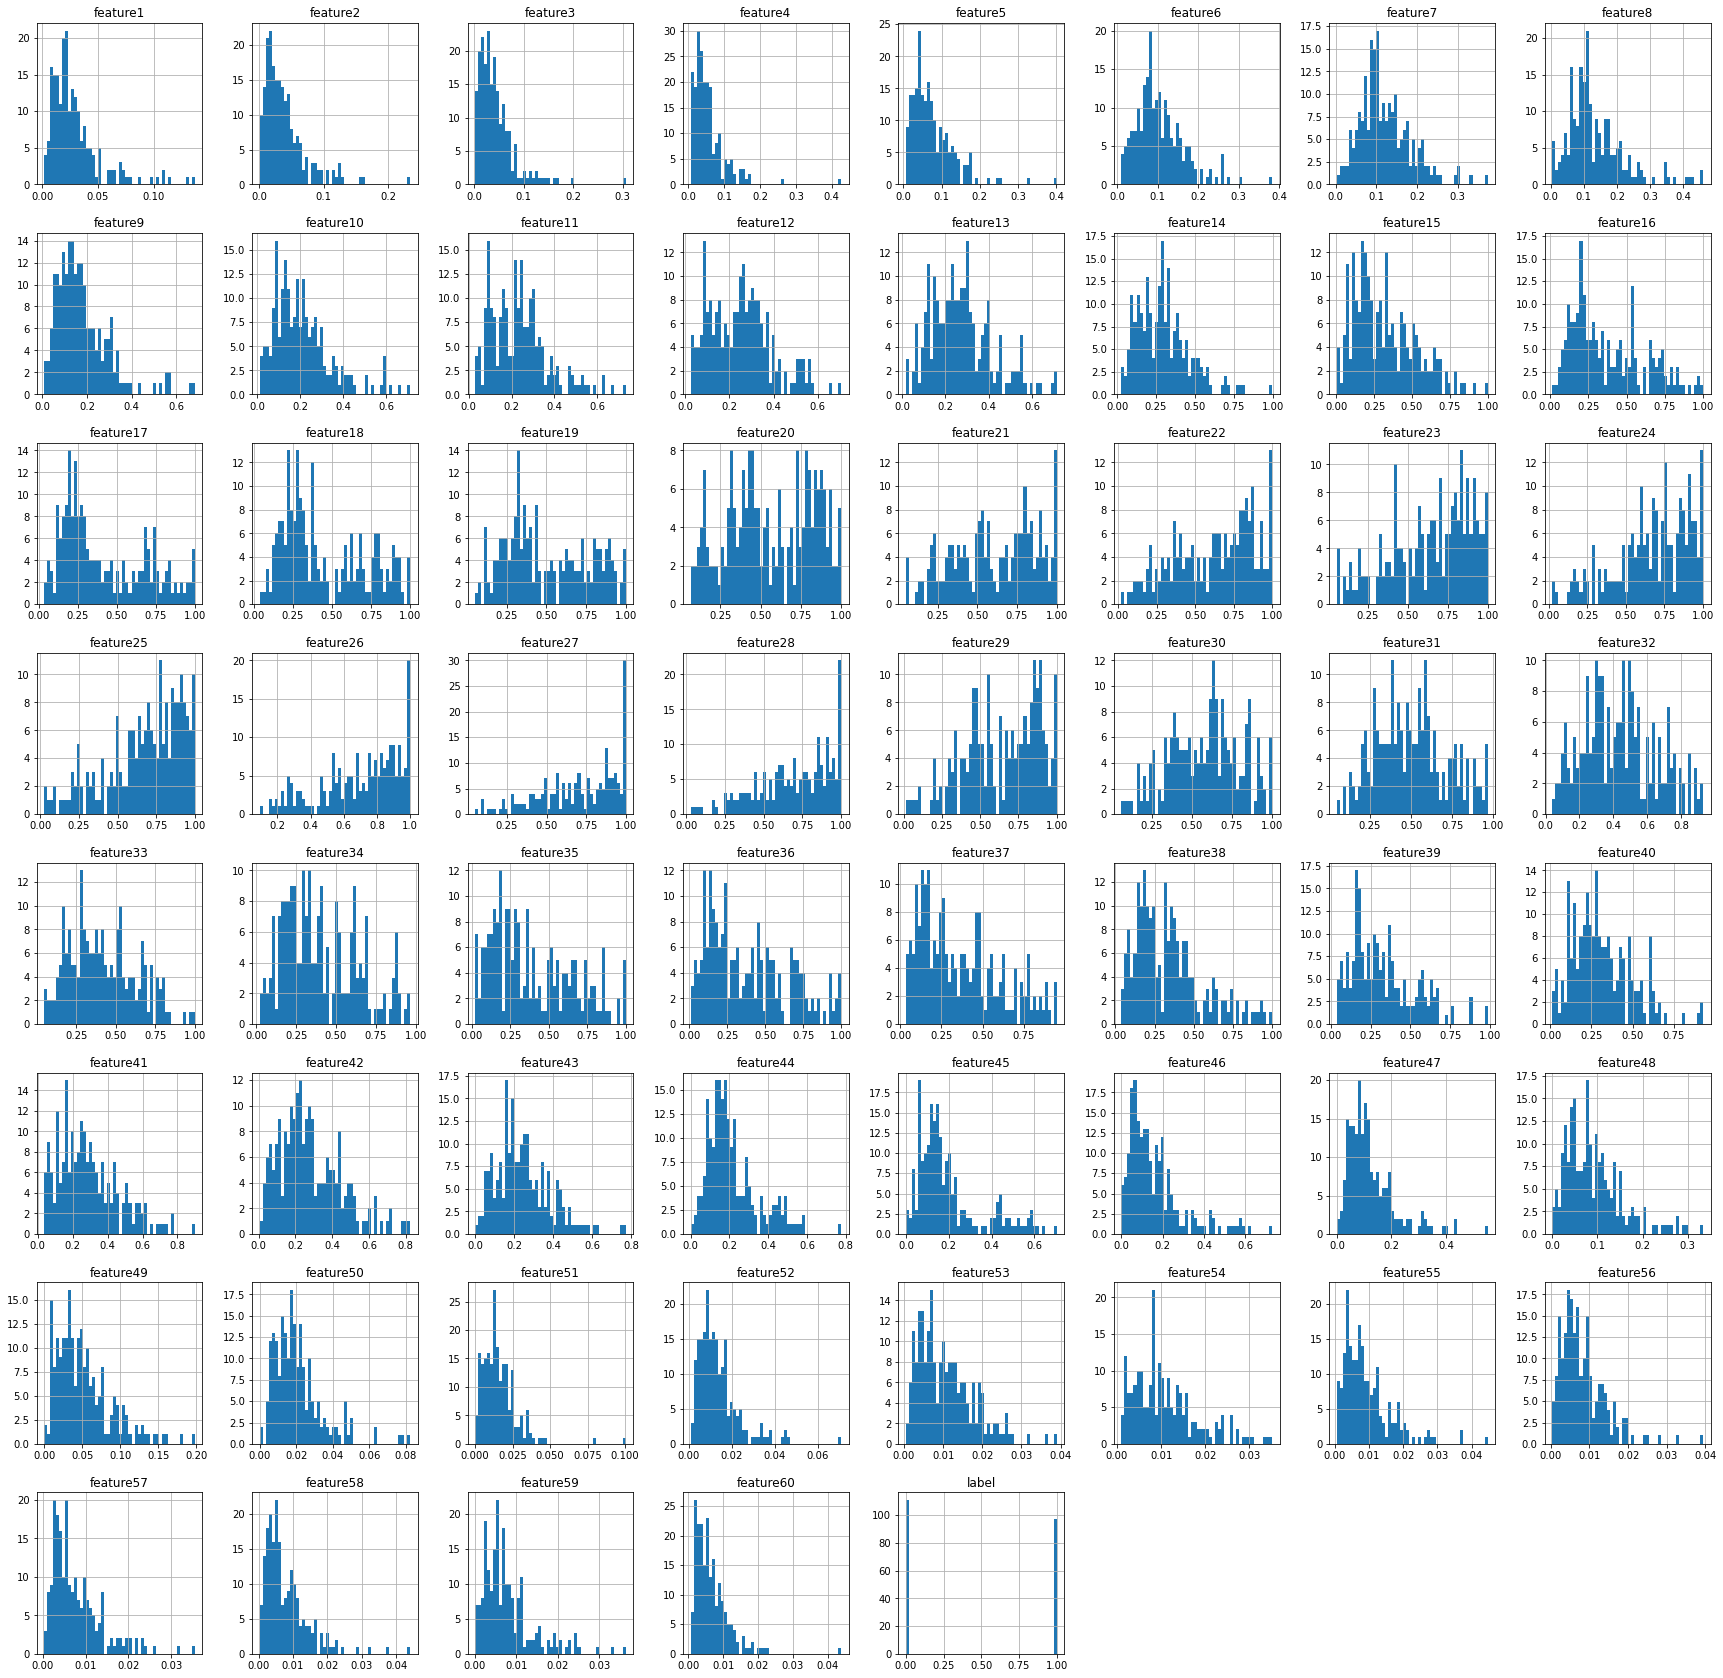

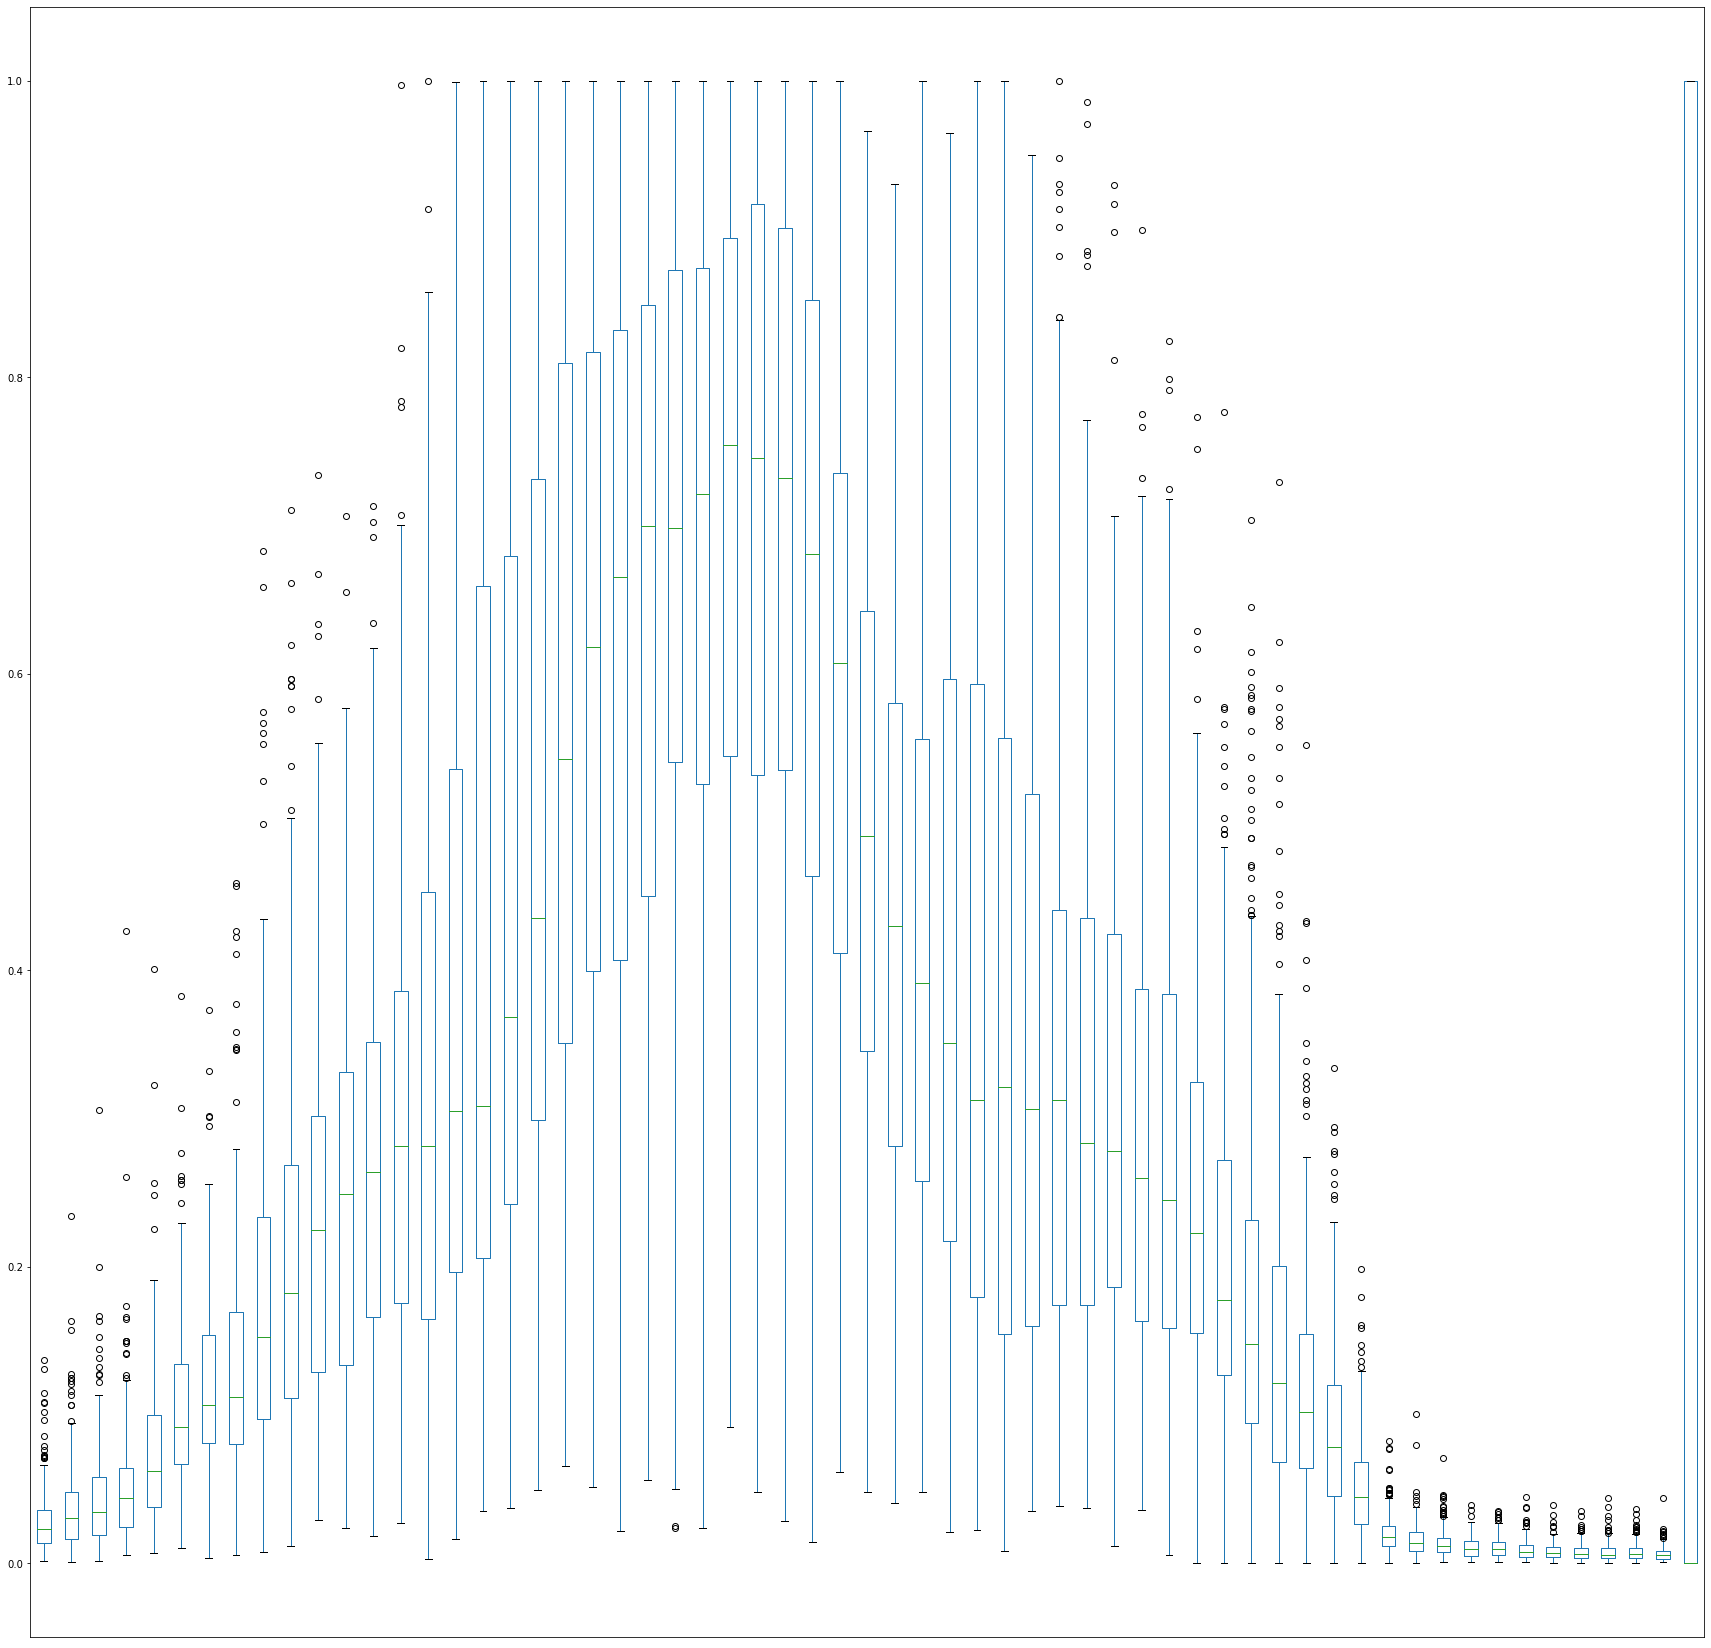

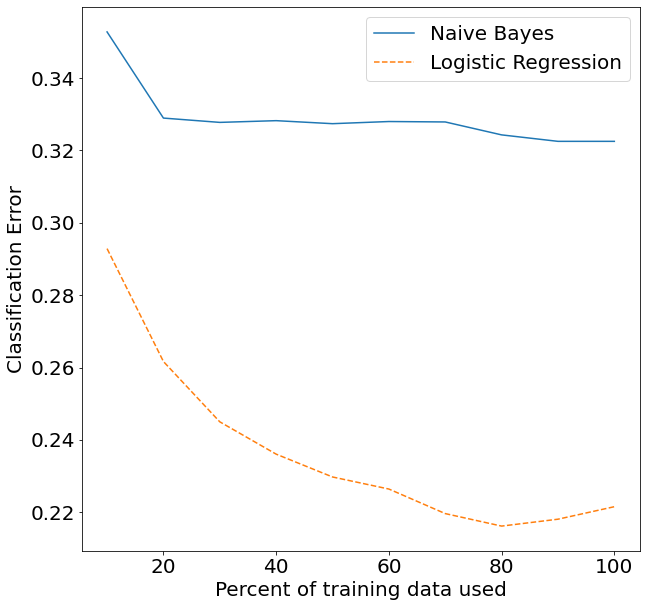

In [12]:
########################################################################################################################

#Attributes

# Each pattern is a set of 60 numbers in the range 0.0 to 1.0.  Each number
# represents the energy within a particular frequency band, integrated over
# a certain period of time.  The integration aperture for higher frequencies
# occur later in time, since these frequencies are transmitted later during
# the chirp.
#
# The label associated with each record contains the letter "R" if the object
# is a rock and "M" if it is a mine (metal cylinder).  The numbers in the
# labels are in increasing order of aspect angle, but they do not encode the
# angle directly.


sonar = pd.read_csv('./datasets/sonar.csv', na_values=missing_values)
#Sonar INFOS for preprocessing
sonar.info()
print(sonar.describe())
# print(sonar.head(5))
#no null or missing values values are present
print('Has Null: ', sonar.isnull().any().any())
print('Has Na: ', sonar.isna().any().any())
print('\nClasses distribution:\n', sonar['label'].value_counts()) #=>even distribution

# PLOTS
sonar.hist(bins=50, figsize=(30,30)) #=> not standardized, label is binary
sonar.plot.box(figsize=(30,30), xticks=[]) #=> data is already normalized between 0 and 1
#
# fig_s2=plt.figure()
# sns.heatmap(sonar.corr(),annot=True) #just to get an idea based on colors

#get irrelevant features. mutual information of 0 means that the feature is independent from the
# label and can thus be dropped
dropped_cols_sonar = sonar.iloc[:,0:-1]
mi_sonar = list(mutual_info_classif(sonar.iloc[:,0:60], sonar.iloc[:,60]))
print('Mutual information', sonar.columns, '\n', mi_sonar)
idx_sonar = [i for i in range(len(mi_sonar)) if mi_sonar[i] < 0.01] #get idx to drop irrelevant features
dropped_cols_sonar.drop(dropped_cols_sonar.columns[idx_sonar], axis=1, inplace=True)


dropped_cols_sonar = dropped_cols_sonar.to_numpy()
sonar = sonar.to_numpy()
Xx_sonar, yy_sonar = dropped_cols_sonar, sonar[:,-1]

sc = StandardScaler()
Xx_sonar_scaled = sc.fit_transform(X=Xx_sonar)

#polynomial features took to long for the amount of runs needed. need scaling again after poly features.
# pf = PolynomialFeatures(degree=3)
# Xx_sonar_poly = pf.fit_transform(Xx_sonar_scaled)

nbc_sonar = NBC(feature_types=['r' for i in range(Xx_sonar_scaled.shape[1])], num_classes=2)
lr_sonar = LogisticRegression(max_iter=200)

# ff = pd.DataFrame(Xx_sonar_scaled)
# ff.hist(bins=50, figsize=(30,30))

tst_errs_nbc_sonar, tst_errs_lr_sonar = compareNBCvsLR(nbc_sonar, lr_sonar,
                                                       Xx_sonar_scaled, Xx_sonar_scaled, yy_sonar, n, 10)
makePlot(tst_errs_nbc_sonar, tst_errs_lr_sonar)
print('Accuracy over ', n, 'runs with NBC (100% of training data): ', 1-tst_errs_nbc_sonar[-1])
print('Accuracy over ', n, 'runs with LR (100% of training data): ', 1-tst_errs_lr_sonar[-1])


########################################################################################################################

**Dataset 6: Sonar Dataset Report**

This dataset did not contain any missing values and all features are continuous and already normalized between 0 and 1.
We applied standardization and also tried out polynomial features, but this was not helpful,
since with so many runs the experiments took too long to compute.
We also played around with dropping most features, which lead to some significant performance increases, and of course,
also much shorter training times,
but since this was not the goal of the task, and no validation set was used, we choose to keep it as an experiment only.
When dropping most features, using polynomial features with degree 3 did result in comparable results,
so there was no clear indicator, that one might be better than the other.

The shape of the NB performance in the plot gave us no surprises,
and also showed a great performance increase in the beginning. We also noted, that it oscillate up and down a tiny bit,
which was in common with the figure provided by the paper.
The LR performance also had a strong increase in performance in the beginning, and ultimately, strongly
outperformed the NB model.


########################################################################################################################
########################################################################################################################



# Short Report:

In this practical we learnt greatly about handling data unbeknownst to us, namely, how to explore data,
to dive deep into the data and to find relationships between the features. We also learnt to try out different techniques
to preprocess data and that there is not a single best approach, in some cases we thought that by applying a technique,
i.e. encodings or feature selection would offer better results, which then turned out to not always be the case.
We also had to think about class imbalances in the data sets and how to approach missing values (e.g. the voting dataset,
where almost 50% of all rows have some sort of missing value).
We had some difficulties with the implementation of the NBC, our first designs turned out to be wrong and inefficient
 and we had to completely redesign our algorithm to avoid needlessly looping over data. The builtin vectorizations
 and broadcastings from numpy were very valuable to learn and to rely on.
 Initially, we also got confused and went into implementing a LDA with multivariate norms for our Gaussian Model,
 and although it gave us some great results, it was ultimately the wrong approach for this practical.

We found that creating visualizations of the data was always useful and helpful to us in this task.

Regarding performance, we noticed that the Gaussian was very fast, and the Multinoulli the slowest.

Contributions:
We initially started this practical together as a group, but after Pascal dropped the course,
Fabian reworked and finished this practical. Nonetheless,
we talked about design decisions, the implementation and the results of the experiments,
 and Vladimir offered very helpful input.
